In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torchmetrics
!pip uninstall -y torch torchvision torchaudio
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 129.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 102.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 107.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninst

In [ ]:
import os
import numpy as np
import torch
import torch.utils.data
import torchvision
from torchvision.models.detection import ssd300_vgg16, SSD300_VGG16_Weights
from PIL import Image
import cv2
import xml.etree.ElementTree as ET
from torchmetrics.detection import MeanAveragePrecision
import torch.nn as nn
import torchvision.transforms as transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import defaultdict
from torchvision.ops import nms

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Paths
root = r'/content/drive/MyDrive/dataset/db'
train_folder = os.path.join(root, 'train')
valid_folder = os.path.join(root, 'valid')
test_folder = os.path.join(root, 'test')
output_folder = os.path.join(root, 'output_detections')
os.makedirs(output_folder, exist_ok=True)

# Dataset Class
class CAMODataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None, class_to_idx=None):
        self.root = root
        self.transforms = transforms
        self.image_dir = os.path.join(root, 'images') if os.path.isdir(os.path.join(root, 'images')) else root
        self.annotation_dir = os.path.join(root, 'annotations') if os.path.isdir(os.path.join(root, 'annotations')) else root
        self.imgs = [f for f in os.listdir(self.image_dir) if f.endswith('.jpg') or f.endswith('.png')]
        self.annotations = []

        if not self.imgs:
            print(f"[WARNING] No images found in {self.image_dir}. Check directory structure.")
            return

        if class_to_idx is None:
            self.class_names = set()
            for img in self.imgs:
                annotation_path = os.path.join(self.annotation_dir, img.replace('.jpg', '.xml').replace('.png', '.xml'))
                if os.path.exists(annotation_path):
                    try:
                        tree = ET.parse(annotation_path)
                        root = tree.getroot()
                        boxes = []
                        labels = []
                        for obj in root.findall('object'):
                            label = obj.find('name').text.strip()
                            self.class_names.add(label)
                            bbox = obj.find('bndbox')
                            xmin = float(bbox.find('xmin').text)
                            ymin = float(bbox.find('ymin').text)
                            xmax = float(bbox.find('xmax').text)
                            ymax = float(bbox.find('ymax').text)
                            boxes.append([xmin, ymin, xmax, ymax])
                            labels.append(label)
                        if boxes:
                            boxes = torch.tensor(boxes, dtype=torch.float32)
                            self.annotations.append({'boxes': boxes, 'labels': labels, 'img': img})
                    except Exception as e:
                        print(f"Skipping {img} due to error: {e}")
                else:
                    print(f"[WARNING] Annotation file not found for {img} at {annotation_path}")
            self.class_to_idx = {cls: idx + 1 for idx, cls in enumerate(sorted(self.class_names))}
            for ann in self.annotations:
                ann['labels'] = torch.tensor([self.class_to_idx[label] for label in ann['labels']], dtype=torch.int64)
            self.imgs = [ann['img'] for ann in self.annotations]
        else:
            self.class_to_idx = class_to_idx
            for img in self.imgs:
                annotation_path = os.path.join(self.annotation_dir, img.replace('.jpg', '.xml').replace('.png', '.xml'))
                if os.path.exists(annotation_path):
                    try:
                        tree = ET.parse(annotation_path)
                        root = tree.getroot()
                        boxes = []
                        labels = []
                        for obj in root.findall('object'):
                            label = obj.find('name').text.strip()
                            if label not in self.class_to_idx:
                                continue
                            bbox = obj.find('bndbox')
                            xmin = float(bbox.find('xmin').text)
                            ymin = float(bbox.find('ymin').text)
                            xmax = float(bbox.find('xmax').text)
                            ymax = float(bbox.find('ymax').text)
                            boxes.append([xmin, ymin, xmax, ymax])
                            labels.append(self.class_to_idx[label])
                        if boxes:
                            boxes = torch.tensor(boxes, dtype=torch.float32)
                            labels = torch.tensor(labels, dtype=torch.int64)
                            self.annotations.append({'boxes': boxes, 'labels': labels, 'img': img})
                    except Exception as e:
                        print(f"Skipping {img} due to error: {e}")
                else:
                    print(f"[WARNING] Annotation file not found for {img} at {annotation_path}")
            self.imgs = [ann['img'] for ann in self.annotations]
        self.idx_to_class = {v: k for k, v in self.class_to_idx.items()}

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.annotations[idx]['img'])
        img_pil = Image.open(img_path).convert('RGB')
        img_tensor = transforms.ToTensor()(img_pil)
        input_tensor = img_tensor
        target = {'boxes': self.annotations[idx]['boxes'], 'labels': self.annotations[idx]['labels']}
        if self.transforms is not None:
            input_tensor = self.transforms(img_pil)
        return input_tensor, target, img_pil

    def __len__(self):
        return len(self.annotations)

def visualize_image(img_pil, target, prediction, idx_to_class, score_threshold=0.5):
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(img_pil)
    for box, label in zip(target['boxes'], target['labels']):
        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='g', facecolor='none')
        ax.add_patch(rect)
        ax.text(xmin, ymin, idx_to_class[label.item()], color='g', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))
    plt.title("Prediction")
    plt.axis('off')
    plt.show()

Using device: cuda


In [ ]:
from torchvision.models.detection import ssdlite320_mobilenet_v3_large
import torchvision.models.detection.ssdlite as ssdlite
import torchvision.transforms as transforms
import torch

# Datasets and Loaders
transform = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])

train_dataset = CAMODataset(train_folder, transforms=transform)
class_to_idx = train_dataset.class_to_idx
valid_dataset = CAMODataset(valid_folder, transforms=transform, class_to_idx=class_to_idx)
test_dataset = CAMODataset(test_folder, transforms=transform, class_to_idx=class_to_idx)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(valid_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

def collate_fn(batch):
    return tuple(zip(*batch))

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn, num_workers=0)

# Load model
model = ssdlite320_mobilenet_v3_large(weights=ssdlite.SSDLite320_MobileNet_V3_Large_Weights.DEFAULT)

# Replace the head
num_classes = len(class_to_idx) + 1  # including background

# Use the same norm_layer as the model (MobileNet uses nn.BatchNorm2d)
norm_layer = torch.nn.BatchNorm2d

model.head.classification_head = ssdlite.SSDLiteClassificationHead(
    in_channels=[672, 960],
    num_anchors=[6, 6],
    num_classes=num_classes,
    norm_layer=norm_layer
)

model.to(device)
model.eval()


[WARNING] Annotation file not found for image398_jpg.rf.64780ceb91efcf159d8c4f56d3396249 (1).jpg at /content/drive/MyDrive/dataset/db/train/annotations/image398_jpg.rf.64780ceb91efcf159d8c4f56d3396249 (1).xml
[WARNING] Annotation file not found for image398_jpg.rf.06b155daf690f3b33a80e0d861e863c1 (1).jpg at /content/drive/MyDrive/dataset/db/train/annotations/image398_jpg.rf.06b155daf690f3b33a80e0d861e863c1 (1).xml
[WARNING] Annotation file not found for image397_jpg.rf.b906308a299bed50e76cc556cd5efc3f (1).jpg at /content/drive/MyDrive/dataset/db/train/annotations/image397_jpg.rf.b906308a299bed50e76cc556cd5efc3f (1).xml
[WARNING] Annotation file not found for image397_jpg.rf.97d548b273414f29d3a9aa129c390ec7 (1).jpg at /content/drive/MyDrive/dataset/db/train/annotations/image397_jpg.rf.97d548b273414f29d3a9aa129c390ec7 (1).xml
[WARNING] Annotation file not found for image396_jpg.rf.d278d650fae3ab58df7c994e56656fd1 (1).jpg at /content/drive/MyDrive/dataset/db/train/annotations/image396_jpg

SSD(
  (backbone): SSDLiteFeatureExtractorMobileNet(
    (features): Sequential(
      (0): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (2): Hardswish()
        )
        (1): InvertedResidual(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
              (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
            (1): Conv2dNormActivation(
              (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
            )
          )
        )
        (2): Invert

In [ ]:
# Helper Functions
def compute_iou(box1, box2):
    xA = max(box1[0], box2[0])
    yA = max(box1[1], box2[1])
    xB = min(box1[2], box2[2])
    yB = min(box1[3], box2[3])
    interW = max(0, xB - xA)
    interH = max(0, yB - yA)
    interArea = interW * interH
    box1Area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2Area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    return interArea / float(box1Area + box2Area - interArea) if (box1Area + box2Area - interArea) > 0 else 0.0

def voc_ap(rec, prec):
    mrec = np.concatenate(([0.], rec, [1.]))
    mpre = np.concatenate(([0.], prec, [0.]))
    for i in range(mpre.size - 1, 0, -1):
        mpre[i - 1] = max(mpre[i - 1], mpre[i])
    i_list = np.where(mrec[1:] != mrec[:-1])[0]
    ap = 0.0
    for i in i_list:
        ap += (mrec[i + 1] - mrec[i]) * mpre[i + 1]
    return ap


Inference on Test Set:   0%|          | 0/14 [00:00<?, ?it/s]

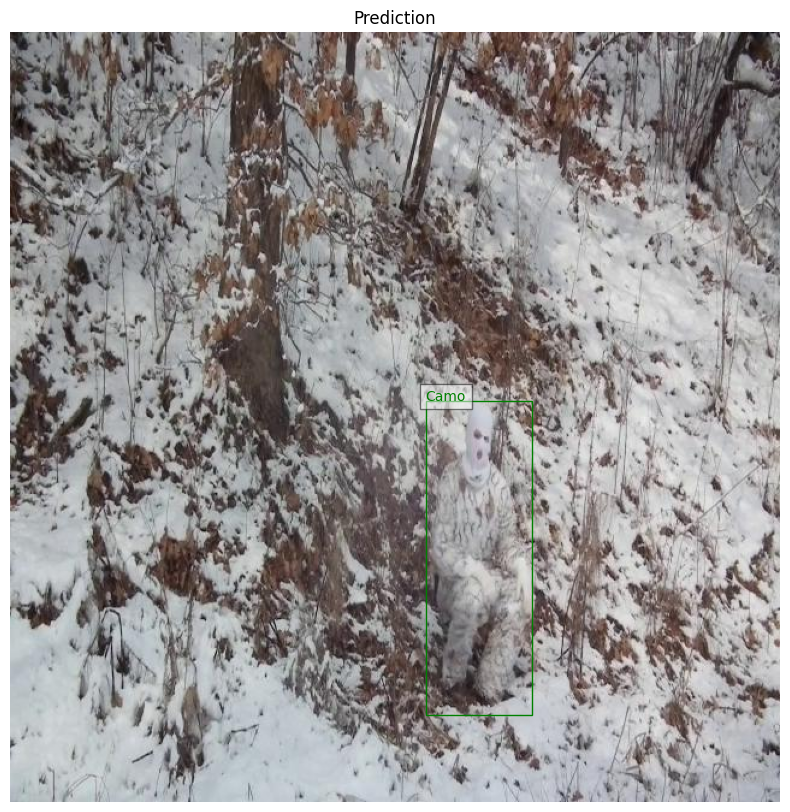

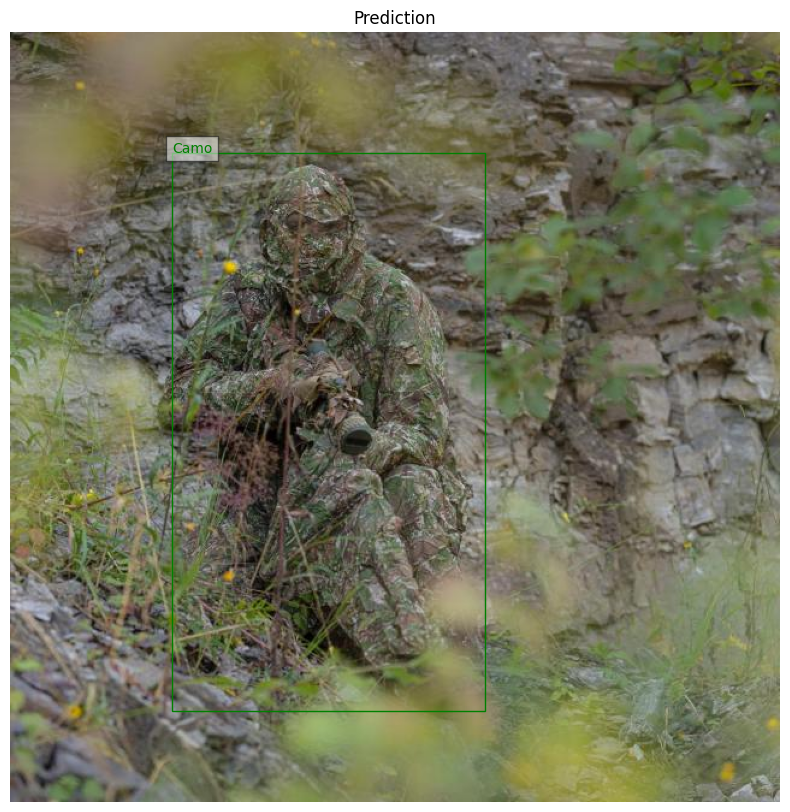

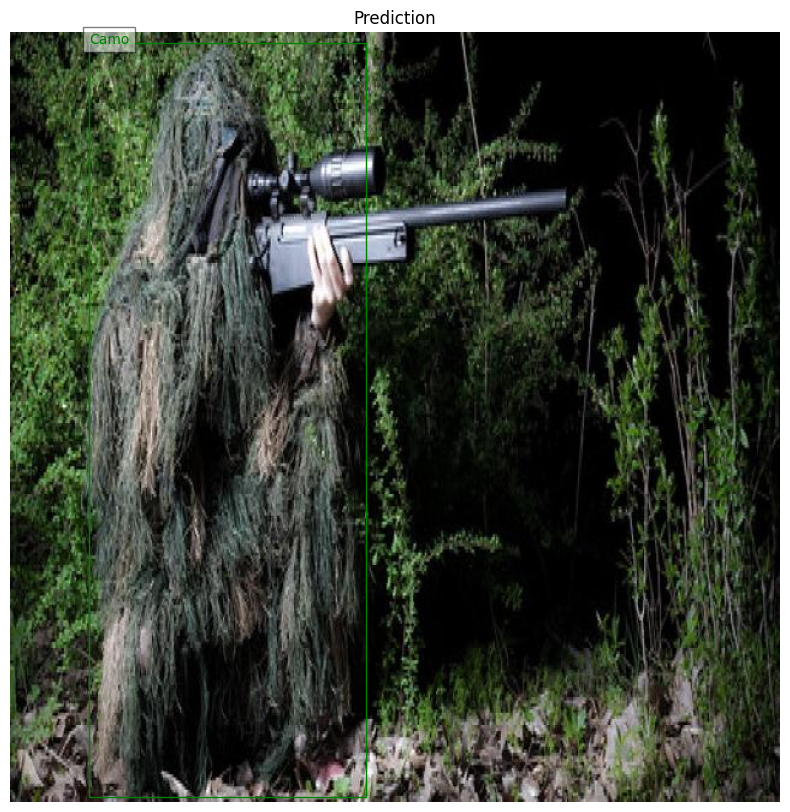

Inference on Test Set: 100%|██████████| 14/14 [00:05<00:00,  2.36it/s]

AP for class 'Camo': 0.0169

Mean Average Precision (mAP): 0.0169

===== Global Metrics (across all classes & images) =====
True Positives (TP): 3
False Positives (FP): 10
False Negatives (FN): 62
Precision: 0.2308
Recall:    0.0462
F1-score:  0.0769
Accuracy:  0.0400


In [ ]:
# Settings
CONFIDENCE_THRESHOLD = 0.5  # Increased from 0.2 to reduce false positives
NMS_THRESHOLD = 0.7
IOU_THRESHOLD = 0.5

# Data Structures
all_annotations = defaultdict(lambda: defaultdict(list))
all_detections = defaultdict(list)
global_TP, global_FP, global_FN = 0, 0, 0

# Preload Annotations
for idx in range(len(test_dataset)):
    _, target, _ = test_dataset[idx]
    image_id = os.path.splitext(test_dataset.annotations[idx]['img'])[0]
    for i, label in enumerate(target['labels']):
        cls_name = test_dataset.idx_to_class[label.item()]
        all_annotations[cls_name][image_id].append({"bbox": target['boxes'][i].tolist(), "detected": False})

# Run Inference and Collect Predictions
with torch.no_grad():
    for i, (images, targets, imgs_pil) in enumerate(tqdm(test_loader, desc="Inference on Test Set")):
        images = [img.to(device) for img in images]
        predictions = model(images)
        for j, (pred, target, img_pil) in enumerate(zip(predictions, targets, imgs_pil)):
            image_id = os.path.splitext(test_dataset.annotations[i * 4 + j]['img'])[0]
            # Move prediction to CPU for visualization
            pred_cpu = {k: v.cpu() for k, v in pred.items()}
            scores = pred_cpu['scores'].numpy()
            boxes = pred_cpu['boxes'].numpy()
            labels = pred_cpu['labels'].numpy()

            filtered_boxes = []
            filtered_scores = []
            filtered_labels = []
            for k in range(len(scores)):
                if scores[k] >= CONFIDENCE_THRESHOLD and (boxes[k][2] - boxes[k][0]) > 20 and (boxes[k][3] - boxes[k][1]) > 20:
                    filtered_boxes.append(boxes[k])
                    filtered_scores.append(scores[k])
                    filtered_labels.append(labels[k])

            if filtered_boxes:
                keep_indices = nms(torch.tensor(filtered_boxes), torch.tensor(filtered_scores), NMS_THRESHOLD)
                filtered_boxes = [filtered_boxes[k] for k in keep_indices]
                filtered_scores = [filtered_scores[k] for k in keep_indices]
                filtered_labels = [filtered_labels[k] for k in keep_indices]

            for box, score, label in zip(filtered_boxes, filtered_scores, filtered_labels):
                label_int = int(label)
                if label_int in test_dataset.idx_to_class:
                    cls_name = test_dataset.idx_to_class[label_int]
                    all_detections[cls_name].append({"image_id": image_id, "confidence": score, "bbox": box})

                all_detections[cls_name].append({"image_id": image_id, "confidence": score, "bbox": box})

            if i < 1 and j < 3:  # Visualize first 3 images of the first batch
                visualize_image(img_pil, target, pred_cpu, test_dataset.idx_to_class)

# Compute Metrics
aps = {}
for cls_name, detections in all_detections.items():
    detections = sorted(detections, key=lambda x: x["confidence"], reverse=True)
    TP_array = np.zeros(len(detections))
    FP_array = np.zeros(len(detections))

    total_gt = sum(len(all_annotations[cls_name][img_id]) for img_id in all_annotations[cls_name])
    for idx, det in enumerate(detections):
        image_id = det["image_id"]
        box_pred = det["bbox"]
        if image_id in all_annotations[cls_name]:
            max_iou = 0
            assigned_gt = None
            for gt in all_annotations[cls_name][image_id]:
                iou = compute_iou(box_pred, gt["bbox"])
                if iou > max_iou:
                    max_iou = iou
                    assigned_gt = gt
            if max_iou >= IOU_THRESHOLD and assigned_gt and not assigned_gt["detected"]:
                TP_array[idx] = 1
                assigned_gt["detected"] = True
            else:
                FP_array[idx] = 1
        else:
            FP_array[idx] = 1

    cum_TP = np.cumsum(TP_array)
    cum_FP = np.cumsum(FP_array)
    rec = cum_TP / (total_gt + 1e-6)
    prec = cum_TP / (cum_TP + cum_FP + 1e-6)

    ap = voc_ap(rec, prec)
    aps[cls_name] = ap
    print(f"AP for class '{cls_name}': {ap:.4f}")

    TP_class = int(cum_TP[-1])
    FP_class = int(cum_FP[-1])
    FN_class = total_gt - TP_class

    global_TP += TP_class
    global_FP += FP_class
    global_FN += FN_class

# Mean Average Precision
mAP = np.mean(list(aps.values())) if aps else 0.0
print(f"\nMean Average Precision (mAP): {mAP:.4f}")

# Global Metrics
precision_global = global_TP / float(global_TP + global_FP + 1e-6)
recall_global = global_TP / float(global_TP + global_FN + 1e-6)
f1_global = 2.0 * (precision_global * recall_global) / (precision_global + recall_global + 1e-6)
accuracy_global = global_TP / float(global_TP + global_FP + global_FN + 1e-6)

print("\n===== Global Metrics (across all classes & images) =====")
print(f"True Positives (TP): {global_TP}")
print(f"False Positives (FP): {global_FP}")
print(f"False Negatives (FN): {global_FN}")
print(f"Precision: {precision_global:.4f}")
print(f"Recall:    {recall_global:.4f}")
print(f"F1-score:  {f1_global:.4f}")
print(f"Accuracy:  {accuracy_global:.4f}")